In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
def concat_csv():
    # Take the path of all the data
    # Read data
    df = pd.read_csv('/content/japandata.csv',header=0)
    df.set_index('Time', inplace=True)
    df = df.fillna(method = 'ffill')
    return df

In [ ]:
df = concat_csv()
print(df.head())  # Hiển thị 5 dòng đầu tiên
print(df.info())  # Kiểm tra kiểu dữ liệu

               Temperature  Wind speed  Relative humidity (%)  \
Time                                                            
1/1/2015 0:00          4.2         1.5                   79.0   
1/1/2015 1:00          4.6         3.6                   68.0   
1/1/2015 2:00          4.7         3.6                   60.0   
1/1/2015 3:00          4.4         4.6                   50.0   
1/1/2015 4:00          2.9         2.6                   49.0   

               Solar radiation  \
Time                             
1/1/2015 0:00              0.0   
1/1/2015 1:00              0.0   
1/1/2015 2:00              0.0   
1/1/2015 3:00              0.0   
1/1/2015 4:00              0.0   

               Active power of purchased electricity at the receiving end  
Time                                                                       
1/1/2015 0:00                                         546.620999           
1/1/2015 1:00                                         587.033331           
1

<ipython-input-199-820969ceda7d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


In [ ]:
def correlation(dataset, threshold):
     col_corr = set()  # Set of all the names of correlated columns
     corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
     num_columns = len(corr_matrix.columns)
     for i in range(num_columns):
         if i != 0:
             if abs(corr_matrix.iloc[i,4 ]) < threshold:
                 colname = corr_matrix.columns[i]
                 col_corr.add(colname)
     return col_corr
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename="/content/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def ordered_train_val_test_split(df, val_size, test_size):
    # Calculate the splitting indices
    val_index = int(len(df) * (1 - val_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_data = df.iloc[:val_index]
    val_data = df.iloc[val_index:test_index]
    test_data = df.iloc[test_index:]

    return train_data, val_data, test_data

In [ ]:
#device = "cuda" if torch.cuda.is_available() else "cpu"

# class LSTM(nn.Module):
#     def __init__(self,input_size=8,hidden_size=256,num_layers=2,seq_length=12):
#         super(LSTM,self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
#         self.fc = nn.Linear(hidden_size*seq_length,seq_length)
#     def forward(self,x):
#         out,(hidden,cell) = self.lstm(x)
#         # out: tensor of shape (batch_size, seq_length, hidden_size)

#         out = out.reshape(out.shape[0],-1)
#         # out: tensor of shape (batch_size, seq_length * hidden_size)

#         out = self.fc(out)
#         # out: shape (batch_size,seq_length)
#         return out

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class LSTM(nn.Module):
    def __init__(self, input_size=8, hidden_size=256, num_layers=2, seq_length=12, dropout=0.3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        # dropout giữa các layer của LSTM (áp dụng nếu num_layers > 1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Dropout sau LSTM trước khi vào fc
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * seq_length, seq_length)

    def forward(self, x):
        out, (hidden, cell) = self.lstm(x)
        out = out.reshape(out.shape[0], -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [ ]:
class Irradiation_Dataset(Dataset):
    def __init__(self,data,target,trainop1=True):
        self.data = data # shape [num_samples,num_feature]
        self.target = target # shape [num_samples,1]
        self.trainop1 = trainop1
    def __len__(self):
        if self.trainop1:
            return self.data.shape[0]//24-1
        else:
            return self.data.shape[0]//24

    def __getitem__(self,index):
        if self.trainop1:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = (index+1)*seq_length
            targets_end_idx = targets_start_idx+24
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

            return torch.tensor(features),torch.tensor(targets)
        else:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = index * seq_length
            targets_end_idx = (index+1)*seq_length
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]
        return torch.tensor(features),torch.tensor(targets)

In [ ]:
print(df)

                 Temperature  Wind speed  Relative humidity (%)  \
Time                                                              
1/1/2015 0:00            4.2         1.5                   79.0   
1/1/2015 1:00            4.6         3.6                   68.0   
1/1/2015 2:00            4.7         3.6                   60.0   
1/1/2015 3:00            4.4         4.6                   50.0   
1/1/2015 4:00            2.9         2.6                   49.0   
...                      ...         ...                    ...   
4/24/2018 19:00         17.6         3.6                   92.0   
4/24/2018 20:00         17.2         2.4                   95.0   
4/24/2018 21:00         16.8         2.6                   94.0   
4/24/2018 22:00         16.7         2.2                   96.0   
4/24/2018 23:00         17.0         2.7                   98.0   

                 Solar radiation  \
Time                               
1/1/2015 0:00                0.0   
1/1/2015 1:00       

In [ ]:
low_corr_columns = correlation(df, 0.3)
print("Các cột có tương quan thấp với cột mục tiêu:", low_corr_columns)

Các cột có tương quan thấp với cột mục tiêu: {'Wind speed', 'Relative humidity (%)'}


In [ ]:
df = df.drop(columns=low_corr_columns)

print("DataFrame sau khi loại bỏ các cột tương quan thấp:")
print(df.head())

DataFrame sau khi loại bỏ các cột tương quan thấp:
               Temperature  Solar radiation  \
Time                                          
1/1/2015 0:00          4.2              0.0   
1/1/2015 1:00          4.6              0.0   
1/1/2015 2:00          4.7              0.0   
1/1/2015 3:00          4.4              0.0   
1/1/2015 4:00          2.9              0.0   

               Active power of purchased electricity at the receiving end  
Time                                                                       
1/1/2015 0:00                                         546.620999           
1/1/2015 1:00                                         587.033331           
1/1/2015 2:00                                         580.412666           
1/1/2015 3:00                                         558.533333           
1/1/2015 4:00                                         593.818332           


In [ ]:
# df = concat_csv()

target_column = 'Active power of purchased electricity at the receiving end'
trainop1 = True

X = df
Y = df[target_column]
Y = pd.DataFrame({target_column: Y})

X_train, X_val, X_test = ordered_train_val_test_split(X,0.1,0.1)
Y_train, Y_val, Y_test = ordered_train_val_test_split(Y,0.1,0.1)

if not trainop1:
    X_train = X_train.drop(target_column,axis=1)
    X_val = X_val.drop(target_column,axis=1)
    X_test = X_test.drop(target_column,axis=1)

In [ ]:
print(df.head())

               Temperature  Solar radiation  \
Time                                          
1/1/2015 0:00          4.2              0.0   
1/1/2015 1:00          4.6              0.0   
1/1/2015 2:00          4.7              0.0   
1/1/2015 3:00          4.4              0.0   
1/1/2015 4:00          2.9              0.0   

               Active power of purchased electricity at the receiving end  
Time                                                                       
1/1/2015 0:00                                         546.620999           
1/1/2015 1:00                                         587.033331           
1/1/2015 2:00                                         580.412666           
1/1/2015 3:00                                         558.533333           
1/1/2015 4:00                                         593.818332           


In [ ]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns).values
X_val = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns).values
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns).values


Y_scaler = StandardScaler()
Y_train = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns).values
Y_val = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns).values
Y_test = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns).values

# print(Y_test)

In [ ]:
print("The shape of the original data:",df.shape)
print("The shape of the train data:",X_train.shape)
print("The shape of the train target:",Y_train.shape)
print("The shape of the val data:",X_val.shape)
print("The shape of the val target:",Y_val.shape)
print("The shape of the test data:",X_test.shape)
print("The shape of the test target:",Y_test.shape)

train_data = Irradiation_Dataset(X_train,Y_train,trainop1=trainop1)
val_data = Irradiation_Dataset(X_val,Y_val,trainop1=trainop1)
test_data = Irradiation_Dataset(X_test,Y_test,trainop1=trainop1)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)
test_data_loader = get_loader(test_data)

The shape of the original data: (29040, 3)
The shape of the train data: (23232, 3)
The shape of the train target: (23232, 1)
The shape of the val data: (2904, 3)
The shape of the val target: (2904, 1)
The shape of the test data: (2904, 3)
The shape of the test target: (2904, 1)
967
120
120


In [ ]:
#HYPERPARAMETERS
input_size = 3
hidden_size = 64
num_layers = 2
sequence_length = 24
learning_rate = 0.01
batch_size = 16
num_epochs = 1000
min_valid_loss = np.inf

In [ ]:
# MODEL
model = LSTM(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             seq_length=sequence_length).to(device=device)

# randn_tensor = torch.randn((16,12,10))
# x = model(randn_tensor)
# x.shape

In [ ]:
#LOSS AND OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        patience: số epoch chờ đợi sau khi validation loss không giảm
        min_delta: mức giảm tối thiểu của validation loss để coi là cải thiện
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter nếu cải thiện
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
print(X)

                 Temperature  Solar radiation  \
Time                                            
1/1/2015 0:00            4.2              0.0   
1/1/2015 1:00            4.6              0.0   
1/1/2015 2:00            4.7              0.0   
1/1/2015 3:00            4.4              0.0   
1/1/2015 4:00            2.9              0.0   
...                      ...              ...   
4/24/2018 19:00         17.6              0.0   
4/24/2018 20:00         17.2              0.0   
4/24/2018 21:00         16.8              0.0   
4/24/2018 22:00         16.7              0.0   
4/24/2018 23:00         17.0              0.0   

                 Active power of purchased electricity at the receiving end  
Time                                                                         
1/1/2015 0:00                                           546.620999           
1/1/2015 1:00                                           587.033331           
1/1/2015 2:00                                     

In [ ]:
input_size = df.shape[1]
print(input_size)

3


In [ ]:
early_stopping = EarlyStopping(patience=20, min_delta=1e-4)  # Bạn có thể điều chỉnh
#TRAIN THE MODEL
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    train_loss = 0
    model.train()
    for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
        data = data.to(device=device,dtype=torch.float)
        target = target.to(device=device,dtype=torch.float).squeeze(2)

        scores = model(data)
        loss = criterion(scores,target)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss += loss.item()
    scheduler.step()
    avg_train_loss = train_loss / len(train_data_loader)
    print("Train Loss:", avg_train_loss)
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        total_scores_val = None
        total_target_val = None
        for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
            data_val = data_val.to(device=device,dtype=torch.float)
            target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

            scores_val = model(data_val)
            loss_val = criterion(scores_val,target_val)

            valid_loss += loss_val.item()
    avg_valid_loss = valid_loss / len(val_data_loader)
    print("Validation Loss:", avg_valid_loss)

    if min_valid_loss > valid_loss/len(val_data_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
        min_valid_loss = valid_loss/len(val_data_loader)
        # Saving State Dict
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
        torch.save(model, "/content/model_predict_.pth.tar")

     # Kiểm tra EarlyStopping
    early_stopping(avg_valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch:  0


100%|██████████| 61/61 [00:01<00:00, 36.95it/s]


Train Loss: 0.7026789970085269


100%|██████████| 8/8 [00:00<00:00, 179.63it/s]


Validation Loss: 1.573865532875061
Validation Loss Decreased(inf--->1.573866 	 Saving The Model
=> Saving checkpoint
Epoch:  1


100%|██████████| 61/61 [00:01<00:00, 55.53it/s]


Train Loss: 0.6164400599530486


100%|██████████| 8/8 [00:00<00:00, 194.11it/s]


Validation Loss: 0.6451971121132374
Validation Loss Decreased(1.573866--->0.645197 	 Saving The Model
=> Saving checkpoint
Epoch:  2


100%|██████████| 61/61 [00:01<00:00, 49.23it/s]


Train Loss: 0.4827988884243809


100%|██████████| 8/8 [00:00<00:00, 87.30it/s]


Validation Loss: 0.3834530618041754
Validation Loss Decreased(0.645197--->0.383453 	 Saving The Model
=> Saving checkpoint
Epoch:  3


100%|██████████| 61/61 [00:01<00:00, 55.47it/s]


Train Loss: 0.40338920520954447


100%|██████████| 8/8 [00:00<00:00, 173.94it/s]


Validation Loss: 0.3726926650851965
Validation Loss Decreased(0.383453--->0.372693 	 Saving The Model
=> Saving checkpoint
Epoch:  4


100%|██████████| 61/61 [00:00<00:00, 68.99it/s]


Train Loss: 0.370068084998209


100%|██████████| 8/8 [00:00<00:00, 208.29it/s]


Validation Loss: 0.34889371506869793
Validation Loss Decreased(0.372693--->0.348894 	 Saving The Model
=> Saving checkpoint
Epoch:  5


100%|██████████| 61/61 [00:00<00:00, 68.20it/s]


Train Loss: 0.3631135684544923


100%|██████████| 8/8 [00:00<00:00, 271.39it/s]


Validation Loss: 0.3462874349206686
Validation Loss Decreased(0.348894--->0.346287 	 Saving The Model
=> Saving checkpoint
Epoch:  6


100%|██████████| 61/61 [00:00<00:00, 102.76it/s]


Train Loss: 0.3626358171955484


100%|██████████| 8/8 [00:00<00:00, 282.45it/s]


Validation Loss: 0.34475963190197945
Validation Loss Decreased(0.346287--->0.344760 	 Saving The Model
=> Saving checkpoint
Epoch:  7


100%|██████████| 61/61 [00:00<00:00, 98.98it/s]


Train Loss: 0.3616337787176742


100%|██████████| 8/8 [00:00<00:00, 236.55it/s]


Validation Loss: 0.3442964646965265
Validation Loss Decreased(0.344760--->0.344296 	 Saving The Model
=> Saving checkpoint
Epoch:  8


100%|██████████| 61/61 [00:00<00:00, 102.69it/s]


Train Loss: 0.36053248446007247


100%|██████████| 8/8 [00:00<00:00, 265.77it/s]


Validation Loss: 0.34387549571692944
Validation Loss Decreased(0.344296--->0.343875 	 Saving The Model
=> Saving checkpoint
Epoch:  9


100%|██████████| 61/61 [00:00<00:00, 99.41it/s]


Train Loss: 0.3583193478769943


100%|██████████| 8/8 [00:00<00:00, 298.67it/s]


Validation Loss: 0.343329718336463
Validation Loss Decreased(0.343875--->0.343330 	 Saving The Model
=> Saving checkpoint
Epoch:  10


100%|██████████| 61/61 [00:00<00:00, 98.72it/s]


Train Loss: 0.35803087055683136


100%|██████████| 8/8 [00:00<00:00, 249.53it/s]


Validation Loss: 0.3427331056445837
Validation Loss Decreased(0.343330--->0.342733 	 Saving The Model
=> Saving checkpoint
Epoch:  11


100%|██████████| 61/61 [00:00<00:00, 103.98it/s]


Train Loss: 0.3587152854096694


100%|██████████| 8/8 [00:00<00:00, 274.25it/s]


Validation Loss: 0.3419945351779461
Validation Loss Decreased(0.342733--->0.341995 	 Saving The Model
=> Saving checkpoint
Epoch:  12


100%|██████████| 61/61 [00:00<00:00, 103.14it/s]


Train Loss: 0.36032381153008974


100%|██████████| 8/8 [00:00<00:00, 266.72it/s]


Validation Loss: 0.34148807264864445
Validation Loss Decreased(0.341995--->0.341488 	 Saving The Model
=> Saving checkpoint
Epoch:  13


100%|██████████| 61/61 [00:00<00:00, 102.75it/s]


Train Loss: 0.36031755377523234


100%|██████████| 8/8 [00:00<00:00, 275.45it/s]


Validation Loss: 0.3408801984041929
Validation Loss Decreased(0.341488--->0.340880 	 Saving The Model
=> Saving checkpoint
Epoch:  14


100%|██████████| 61/61 [00:00<00:00, 105.86it/s]


Train Loss: 0.358091800672109


100%|██████████| 8/8 [00:00<00:00, 270.13it/s]


Validation Loss: 0.34044436179101467
Validation Loss Decreased(0.340880--->0.340444 	 Saving The Model
=> Saving checkpoint
Epoch:  15


100%|██████████| 61/61 [00:00<00:00, 96.37it/s]


Train Loss: 0.3629292796869747


100%|██████████| 8/8 [00:00<00:00, 256.55it/s]


Validation Loss: 0.33977372013032436
Validation Loss Decreased(0.340444--->0.339774 	 Saving The Model
=> Saving checkpoint
Epoch:  16


100%|██████████| 61/61 [00:00<00:00, 96.04it/s]


Train Loss: 0.3612954085234736


100%|██████████| 8/8 [00:00<00:00, 266.31it/s]


Validation Loss: 0.33930383808910847
Validation Loss Decreased(0.339774--->0.339304 	 Saving The Model
=> Saving checkpoint
Epoch:  17


100%|██████████| 61/61 [00:00<00:00, 101.97it/s]


Train Loss: 0.3576959685468283


100%|██████████| 8/8 [00:00<00:00, 270.98it/s]


Validation Loss: 0.3388109505176544
Validation Loss Decreased(0.339304--->0.338811 	 Saving The Model
=> Saving checkpoint
Epoch:  18


100%|██████████| 61/61 [00:00<00:00, 102.14it/s]


Train Loss: 0.3592829058160547


100%|██████████| 8/8 [00:00<00:00, 269.63it/s]


Validation Loss: 0.33818904496729374
Validation Loss Decreased(0.338811--->0.338189 	 Saving The Model
=> Saving checkpoint
Epoch:  19


100%|██████████| 61/61 [00:00<00:00, 103.19it/s]


Train Loss: 0.356387088044745


100%|██████████| 8/8 [00:00<00:00, 236.15it/s]


Validation Loss: 0.33763255923986435
Validation Loss Decreased(0.338189--->0.337633 	 Saving The Model
=> Saving checkpoint
Epoch:  20


100%|██████████| 61/61 [00:00<00:00, 101.63it/s]


Train Loss: 0.3606629592717671


100%|██████████| 8/8 [00:00<00:00, 263.69it/s]


Validation Loss: 0.33706338331103325
Validation Loss Decreased(0.337633--->0.337063 	 Saving The Model
=> Saving checkpoint
Epoch:  21


100%|██████████| 61/61 [00:00<00:00, 75.36it/s]


Train Loss: 0.35983491078263424


100%|██████████| 8/8 [00:00<00:00, 220.14it/s]


Validation Loss: 0.3365657217800617
Validation Loss Decreased(0.337063--->0.336566 	 Saving The Model
=> Saving checkpoint
Epoch:  22


100%|██████████| 61/61 [00:00<00:00, 71.92it/s]


Train Loss: 0.3579240300860561


100%|██████████| 8/8 [00:00<00:00, 188.33it/s]


Validation Loss: 0.336020790040493
Validation Loss Decreased(0.336566--->0.336021 	 Saving The Model
=> Saving checkpoint
Epoch:  23


100%|██████████| 61/61 [00:00<00:00, 68.94it/s]


Train Loss: 0.35344032845536216


100%|██████████| 8/8 [00:00<00:00, 182.19it/s]


Validation Loss: 0.33579805865883827
Validation Loss Decreased(0.336021--->0.335798 	 Saving The Model
=> Saving checkpoint
Epoch:  24


100%|██████████| 61/61 [00:00<00:00, 76.04it/s]


Train Loss: 0.35572432641123164


100%|██████████| 8/8 [00:00<00:00, 280.49it/s]


Validation Loss: 0.335514634847641
Validation Loss Decreased(0.335798--->0.335515 	 Saving The Model
=> Saving checkpoint
Epoch:  25


100%|██████████| 61/61 [00:00<00:00, 101.02it/s]


Train Loss: 0.35493436272515627


100%|██████████| 8/8 [00:00<00:00, 265.91it/s]


Validation Loss: 0.33517971634864807
Validation Loss Decreased(0.335515--->0.335180 	 Saving The Model
=> Saving checkpoint
Epoch:  26


100%|██████████| 61/61 [00:00<00:00, 103.87it/s]


Train Loss: 0.3520863879410947


100%|██████████| 8/8 [00:00<00:00, 250.59it/s]


Validation Loss: 0.33461105078458786
Validation Loss Decreased(0.335180--->0.334611 	 Saving The Model
=> Saving checkpoint
Epoch:  27


100%|██████████| 61/61 [00:00<00:00, 101.13it/s]


Train Loss: 0.35419217790247964


100%|██████████| 8/8 [00:00<00:00, 262.03it/s]


Validation Loss: 0.3343365825712681
Validation Loss Decreased(0.334611--->0.334337 	 Saving The Model
=> Saving checkpoint
Epoch:  28


100%|██████████| 61/61 [00:00<00:00, 102.39it/s]


Train Loss: 0.3539183430495809


100%|██████████| 8/8 [00:00<00:00, 297.31it/s]


Validation Loss: 0.3337559085339308
Validation Loss Decreased(0.334337--->0.333756 	 Saving The Model
=> Saving checkpoint
Epoch:  29


100%|██████████| 61/61 [00:00<00:00, 105.39it/s]


Train Loss: 0.3516895680642519


100%|██████████| 8/8 [00:00<00:00, 255.38it/s]


Validation Loss: 0.33370067551732063
Validation Loss Decreased(0.333756--->0.333701 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  30


100%|██████████| 61/61 [00:00<00:00, 102.53it/s]


Train Loss: 0.3542836116718464


100%|██████████| 8/8 [00:00<00:00, 253.26it/s]


Validation Loss: 0.3332568407058716
Validation Loss Decreased(0.333701--->0.333257 	 Saving The Model
=> Saving checkpoint
Epoch:  31


100%|██████████| 61/61 [00:00<00:00, 103.96it/s]


Train Loss: 0.3525075653537375


100%|██████████| 8/8 [00:00<00:00, 250.90it/s]


Validation Loss: 0.3331295270472765
Validation Loss Decreased(0.333257--->0.333130 	 Saving The Model
=> Saving checkpoint
Epoch:  32


100%|██████████| 61/61 [00:00<00:00, 101.95it/s]


Train Loss: 0.35057701756719684


100%|██████████| 8/8 [00:00<00:00, 216.91it/s]


Validation Loss: 0.3329805936664343
Validation Loss Decreased(0.333130--->0.332981 	 Saving The Model
=> Saving checkpoint
Epoch:  33


100%|██████████| 61/61 [00:00<00:00, 100.70it/s]


Train Loss: 0.3559571139392306


100%|██████████| 8/8 [00:00<00:00, 250.91it/s]


Validation Loss: 0.3328934758901596
Validation Loss Decreased(0.332981--->0.332893 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  34


100%|██████████| 61/61 [00:00<00:00, 106.50it/s]


Train Loss: 0.35326556189626945


100%|██████████| 8/8 [00:00<00:00, 259.68it/s]


Validation Loss: 0.33285389095544815
Validation Loss Decreased(0.332893--->0.332854 	 Saving The Model
=> Saving checkpoint
Epoch:  35


100%|██████████| 61/61 [00:00<00:00, 98.15it/s]


Train Loss: 0.35354307159537174


100%|██████████| 8/8 [00:00<00:00, 254.73it/s]


Validation Loss: 0.3330157585442066
EarlyStopping counter: 1 out of 20
Epoch:  36


100%|██████████| 61/61 [00:00<00:00, 100.28it/s]


Train Loss: 0.3526866098896402


100%|██████████| 8/8 [00:00<00:00, 251.76it/s]


Validation Loss: 0.3328161686658859
Validation Loss Decreased(0.332854--->0.332816 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  37


100%|██████████| 61/61 [00:00<00:00, 101.76it/s]


Train Loss: 0.3512672802708188


100%|██████████| 8/8 [00:00<00:00, 276.17it/s]


Validation Loss: 0.3324897475540638
Validation Loss Decreased(0.332816--->0.332490 	 Saving The Model
=> Saving checkpoint
Epoch:  38


100%|██████████| 61/61 [00:00<00:00, 98.53it/s]


Train Loss: 0.3500629292159784


100%|██████████| 8/8 [00:00<00:00, 260.69it/s]


Validation Loss: 0.3327603545039892
EarlyStopping counter: 1 out of 20
Epoch:  39


100%|██████████| 61/61 [00:00<00:00, 100.06it/s]


Train Loss: 0.34906962135287584


100%|██████████| 8/8 [00:00<00:00, 155.37it/s]


Validation Loss: 0.33281598798930645
EarlyStopping counter: 2 out of 20
Epoch:  40


100%|██████████| 61/61 [00:00<00:00, 70.79it/s]


Train Loss: 0.3525242127600263


100%|██████████| 8/8 [00:00<00:00, 215.39it/s]


Validation Loss: 0.3327973075211048
EarlyStopping counter: 3 out of 20
Epoch:  41


100%|██████████| 61/61 [00:00<00:00, 73.04it/s]


Train Loss: 0.3520034727503042


100%|██████████| 8/8 [00:00<00:00, 138.04it/s]


Validation Loss: 0.3330211974680424
EarlyStopping counter: 4 out of 20
Epoch:  42


100%|██████████| 61/61 [00:00<00:00, 63.03it/s]


Train Loss: 0.34713173547729115


100%|██████████| 8/8 [00:00<00:00, 148.35it/s]


Validation Loss: 0.3331135790795088
EarlyStopping counter: 5 out of 20
Epoch:  43


100%|██████████| 61/61 [00:00<00:00, 91.16it/s]


Train Loss: 0.3474031091957796


100%|██████████| 8/8 [00:00<00:00, 288.63it/s]


Validation Loss: 0.33299356885254383
EarlyStopping counter: 6 out of 20
Epoch:  44


100%|██████████| 61/61 [00:00<00:00, 101.42it/s]


Train Loss: 0.3489503036024141


100%|██████████| 8/8 [00:00<00:00, 255.89it/s]


Validation Loss: 0.3330357875674963
EarlyStopping counter: 7 out of 20
Epoch:  45


100%|██████████| 61/61 [00:00<00:00, 99.37it/s] 


Train Loss: 0.35114310657391784


100%|██████████| 8/8 [00:00<00:00, 256.17it/s]


Validation Loss: 0.33332398161292076
EarlyStopping counter: 8 out of 20
Epoch:  46


100%|██████████| 61/61 [00:00<00:00, 100.09it/s]


Train Loss: 0.3480003087735567


100%|██████████| 8/8 [00:00<00:00, 253.18it/s]


Validation Loss: 0.33331212773919106
EarlyStopping counter: 9 out of 20
Epoch:  47


100%|██████████| 61/61 [00:00<00:00, 103.57it/s]


Train Loss: 0.3510396682092401


100%|██████████| 8/8 [00:00<00:00, 234.84it/s]


Validation Loss: 0.33338411897420883
EarlyStopping counter: 10 out of 20
Epoch:  48


100%|██████████| 61/61 [00:00<00:00, 93.60it/s]


Train Loss: 0.3502675076244307


100%|██████████| 8/8 [00:00<00:00, 270.37it/s]


Validation Loss: 0.3335437495261431
EarlyStopping counter: 11 out of 20
Epoch:  49


100%|██████████| 61/61 [00:00<00:00, 94.94it/s]


Train Loss: 0.3463448823475447


100%|██████████| 8/8 [00:00<00:00, 251.78it/s]


Validation Loss: 0.33390626683831215
EarlyStopping counter: 12 out of 20
Epoch:  50


100%|██████████| 61/61 [00:00<00:00, 97.89it/s]


Train Loss: 0.3472762458392831


100%|██████████| 8/8 [00:00<00:00, 239.28it/s]


Validation Loss: 0.33415220119059086
EarlyStopping counter: 13 out of 20
Epoch:  51


100%|██████████| 61/61 [00:00<00:00, 101.96it/s]


Train Loss: 0.34815387452234986


100%|██████████| 8/8 [00:00<00:00, 270.66it/s]


Validation Loss: 0.33417269214987755
EarlyStopping counter: 14 out of 20
Epoch:  52


100%|██████████| 61/61 [00:00<00:00, 100.85it/s]


Train Loss: 0.35063486314210734


100%|██████████| 8/8 [00:00<00:00, 190.88it/s]


Validation Loss: 0.33460828848183155
EarlyStopping counter: 15 out of 20
Epoch:  53


100%|██████████| 61/61 [00:00<00:00, 101.08it/s]


Train Loss: 0.3499535355167311


100%|██████████| 8/8 [00:00<00:00, 254.55it/s]


Validation Loss: 0.3349186759442091
EarlyStopping counter: 16 out of 20
Epoch:  54


100%|██████████| 61/61 [00:00<00:00, 99.65it/s] 


Train Loss: 0.3478515459621539


100%|██████████| 8/8 [00:00<00:00, 277.55it/s]


Validation Loss: 0.33570115081965923
EarlyStopping counter: 17 out of 20
Epoch:  55


100%|██████████| 61/61 [00:00<00:00, 97.71it/s]


Train Loss: 0.348351390268959


100%|██████████| 8/8 [00:00<00:00, 279.17it/s]


Validation Loss: 0.33560586348176
EarlyStopping counter: 18 out of 20
Epoch:  56


100%|██████████| 61/61 [00:00<00:00, 99.15it/s]


Train Loss: 0.3494354149357217


100%|██████████| 8/8 [00:00<00:00, 243.96it/s]


Validation Loss: 0.33551829494535923
EarlyStopping counter: 19 out of 20
Epoch:  57


100%|██████████| 61/61 [00:00<00:00, 101.21it/s]


Train Loss: 0.34787934823114364


100%|██████████| 8/8 [00:00<00:00, 274.98it/s]

Validation Loss: 0.3359846957027912
EarlyStopping counter: 20 out of 20
Early stopping triggered


In [ ]:
model = torch.load("/content/model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()

LSTM(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1536, out_features=24, bias=True)
)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
model = torch.load("/content/model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()


# num_equal_values = np.count_nonzero(all_targets <= 5.3586226e-06)

# print("Number of values equal to 5.3576226e-06:", num_equal_values)
mask_all_targets = (all_targets > 5.3586226e-06).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)

# print(all_targets)
# print("==============================================")
# print(all_scores)

# print(mask_all_targets.shape)
# # print(mask_all_scores.shape)

def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae

mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)

# mae = mean_absolute_error(all_targets,all_scores)
# mse = mean_squared_error(all_targets,all_scores)
print(mae)
print(mse)

100%|██████████| 8/8 [00:00<00:00, 264.24it/s]

49.71707605794499
5228.910099033514


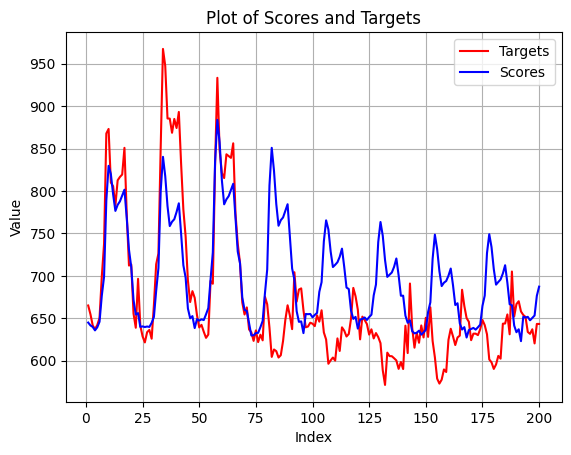

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example numpy arrays

# Create x values (assuming scores are plotted against index)
x = np.arange(len(all_scores[0:200])) + 1

# Plot both arrays on the same graph with different colors

plt.plot(x, all_targets[0:200], color='red', label='Targets')
plt.plot(x, all_scores[0:200], color='blue', label='Scores')

# Adding labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of Scores and Targets')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(all_targets, all_scores)
print("R² score:", r2)

R² score: 0.47732714939436427


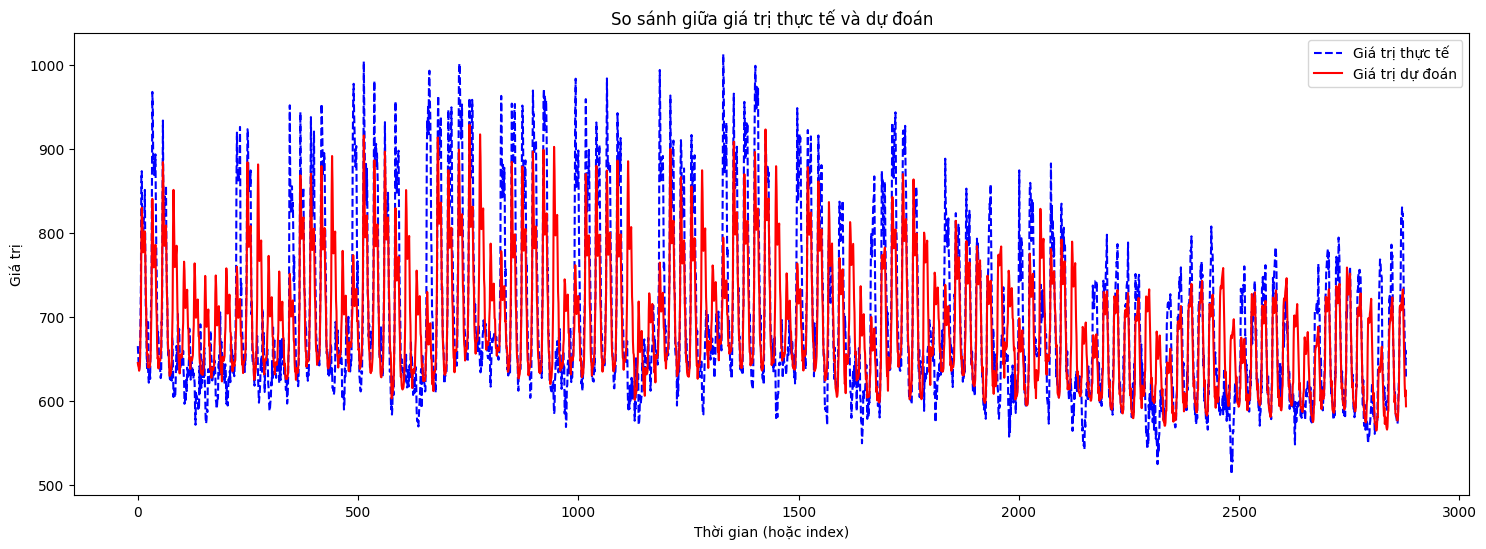

In [ ]:
import matplotlib.pyplot as plt

# Vẽ giá trị thực tế và dự đoán
plt.figure(figsize=(18, 6))
plt.plot(all_targets, label="Giá trị thực tế", color='blue', linestyle='dashed')
plt.plot(all_scores, label="Giá trị dự đoán", color='red')
plt.xlabel("Thời gian (hoặc index)")
plt.ylabel("Giá trị")
plt.title("So sánh giữa giá trị thực tế và dự đoán")
plt.legend()
plt.show()